In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.tree import DecisionTreeClassifier
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [2]:
# just checking to see how my pickle file reads into the notebook
brfss_2009 = pd.read_pickle('./Pickled_Data/brfss_2009.pkl')
brfss_2010 = pd.read_pickle('./Pickled_Data/brfss_2010.pkl')
brfss_2011 = pd.read_pickle('./Pickled_Data/brfss_2011.pkl')
brfss_2012 = pd.read_pickle('./Pickled_Data/brfss_2012.pkl')

In [3]:
# creating a dataframe with data from all years
brfss_total = pd.concat([brfss_2009, brfss_2010, brfss_2011, brfss_2012], ignore_index=True)

In [4]:
#checking nulls
brfss_total.isna().sum()

_STATE            0
DISPCODE          0
GENHLTH          20
PHYSHLTH          9
MENTHLTH          5
POORHLTH     892257
SMOKE100       6844
SMOKDAY2    1014179
STOPSMK2    1564529
USENOW3       13155
AGE               2
HISPANC2          1
MRACE             0
ORACE2      1828502
MARITAL         868
CHILDREN       1383
EDUCA          1293
EMPLOY         1625
INCOME2        2618
RENTHOM1     821587
SEX               0
EXERANY2      20737
QLACTLM2      35533
AVEDRNK2     983529
DRNK3GE5     984572
QLREST2      933492
SLEPTIME    1732597
SCNTMONY    1711675
SCNTMEAL    1702903
ACEDEPRS    1747963
ACEDRINK    1748039
ACEDRUGS    1748057
ACEPRISN    1748066
ACEDIVRC    1748078
ACEPUNCH    1748102
ACEHURT     1748129
ACESWEAR    1748166
ACETOUCH    1748189
ACETTHEM    1748229
ACEHVSEX    1748276
MSCODE       197222
_IMPAGE           0
_RFHLTH           0
_SMOKER3          0
_RFSMOK3          0
_PRACE          751
_EDUCAG           0
_INCOMG           0
_TOTINDA          0
dtype: int64

In [5]:
# since I'm interested specifically in ACE then any row with null values for those questions will be dropped
brfss_total.dropna(subset=['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX'], inplace=True)

In [6]:
brfss_total.head()

,_STATE,DISPCODE,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,SMOKE100,SMOKDAY2,STOPSMK2,USENOW3,...,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_RFSMOK3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
14697,5.0,110.0,2.0,88.0,88.0,NaN,2.0,NaN,NaN,3.0,...,1.0,5.0,53.0,1.0,4.0,1.0,1.0,3.0,5.0,1.0
14699,5.0,110.0,4.0,15.0,77.0,88.0,1.0,3.0,NaN,3.0,...,1.0,5.0,64.0,2.0,3.0,1.0,1.0,2.0,2.0,1.0
14700,5.0,110.0,2.0,6.0,88.0,6.0,2.0,NaN,NaN,3.0,...,1.0,5.0,58.0,1.0,4.0,1.0,1.0,3.0,2.0,1.0
14701,5.0,110.0,5.0,30.0,88.0,88.0,2.0,NaN,NaN,3.0,...,1.0,5.0,76.0,2.0,4.0,1.0,1.0,1.0,9.0,2.0
14704,5.0,110.0,4.0,13.0,88.0,88.0,1.0,3.0,NaN,3.0,...,9.0,5.0,82.0,2.0,3.0,1.0,1.0,2.0,9.0,2.0


In [7]:
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117555 entries, 14697 to 1851207
Data columns (total 49 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    117555 non-null  float64
 1   DISPCODE  117555 non-null  float64
 2   GENHLTH   117555 non-null  float64
 3   PHYSHLTH  117555 non-null  float64
 4   MENTHLTH  117555 non-null  float64
 5   POORHLTH  60291 non-null   float64
 6   SMOKE100  117555 non-null  float64
 7   SMOKDAY2  55545 non-null   float64
 8   STOPSMK2  19259 non-null   float64
 9   USENOW3   117555 non-null  float64
 10  AGE       117555 non-null  float64
 11  HISPANC2  117555 non-null  float64
 12  MRACE     117555 non-null  object 
 13  ORACE2    3612 non-null    float64
 14  MARITAL   117555 non-null  float64
 15  CHILDREN  117534 non-null  float64
 16  EDUCA     117555 non-null  float64
 17  EMPLOY    117555 non-null  float64
 18  INCOME2   117492 non-null  float64
 19  RENTHOM1  89554 non-null   float64
 20 

In [8]:
# will drop columns that are used to calculate other variables that I won't be dropping such as 'AGE', 'GENHLTH', 'SMOKE100', 'SMOKDAY2',
# '_RFSMOK3', 'MRACE', 'ORACE2', 'EDUCA', 'INCOME2', 'EXERANY2' and any 50% or more null values
brfss_total.drop(columns = ['AGE', 'GENHLTH', 'SMOKE100', 'SMOKDAY2','_RFSMOK3', 'MRACE', 'ORACE2', 'EDUCA', 'INCOME2', 'EXERANY2', 
                            'SCNTMEAL', 'SCNTMONY', 'SLEPTIME', 'ORACE2', 'POORHLTH', 'QLREST2', 'AVEDRNK2', 'DRNK3GE5', 'STOPSMK2'],
                            inplace=True)

In [9]:
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117555 entries, 14697 to 1851207
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    117555 non-null  float64
 1   DISPCODE  117555 non-null  float64
 2   PHYSHLTH  117555 non-null  float64
 3   MENTHLTH  117555 non-null  float64
 4   USENOW3   117555 non-null  float64
 5   HISPANC2  117555 non-null  float64
 6   MARITAL   117555 non-null  float64
 7   CHILDREN  117534 non-null  float64
 8   EMPLOY    117555 non-null  float64
 9   RENTHOM1  89554 non-null   float64
 10  SEX       117555 non-null  float64
 11  QLACTLM2  117555 non-null  float64
 12  ACEDEPRS  117555 non-null  float64
 13  ACEDRINK  117555 non-null  float64
 14  ACEDRUGS  117555 non-null  float64
 15  ACEPRISN  117555 non-null  float64
 16  ACEDIVRC  117555 non-null  float64
 17  ACEPUNCH  117555 non-null  float64
 18  ACEHURT   117555 non-null  float64
 19  ACESWEAR  117555 non-null  float64
 20 

In [10]:
# replacing all don't knows, refused answers or none with zeros
brfss_total = brfss_total.replace({77:0, 88:0, 99:0, 7:0, 8:0, 9:0})

In [11]:
# will replace nulls with 0
brfss_total['RENTHOM1'].fillna(0, inplace = True)

In [12]:
brfss_total['MSCODE'].fillna(0, inplace = True)

In [13]:
brfss_total['CHILDREN'].fillna(0, inplace = True)

In [14]:
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117555 entries, 14697 to 1851207
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    117555 non-null  float64
 1   DISPCODE  117555 non-null  float64
 2   PHYSHLTH  117555 non-null  float64
 3   MENTHLTH  117555 non-null  float64
 4   USENOW3   117555 non-null  float64
 5   HISPANC2  117555 non-null  float64
 6   MARITAL   117555 non-null  float64
 7   CHILDREN  117555 non-null  float64
 8   EMPLOY    117555 non-null  float64
 9   RENTHOM1  117555 non-null  float64
 10  SEX       117555 non-null  float64
 11  QLACTLM2  117555 non-null  float64
 12  ACEDEPRS  117555 non-null  float64
 13  ACEDRINK  117555 non-null  float64
 14  ACEDRUGS  117555 non-null  float64
 15  ACEPRISN  117555 non-null  float64
 16  ACEDIVRC  117555 non-null  float64
 17  ACEPUNCH  117555 non-null  float64
 18  ACEHURT   117555 non-null  float64
 19  ACESWEAR  117555 non-null  float64
 20 

In [15]:
# saving brfss_total as a pickle file
brfss_total.to_pickle('./Pickled_Data/brfss_total.pkl')

**Variables I will try to predict with my models:**
- USENOW3: Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
    - classification
- QLACTLM2: Are you limited in any way in any activities because of physical, mental, or emotional problems?
    - classification
- _RFHLTH: Adults with good or better health vs. fair or poor health
    - classification
    - based off of GENHLTH
- _SMOKER3: Four-level smoker status: Everyday smoker, Someday smoker, Former smoker, Non-smoker
    - classification
    - based off of SMOKE100 & SMOKEDAY

In [34]:
X = brfss_total[['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [35]:
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [36]:
# Baselines for tobacco product using
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [37]:
# baseline for activity levels being hindered
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [38]:
# baseline for health status
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [39]:
# baseline for smoker category
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [60]:
X_train, X_test, y_train_tobacco, y_test_tobacco = train_test_split(X, y_tobacco, stratify=y_tobacco)
X_train2, X_test2, y_train_activity, y_test_activity = train_test_split(X, y_activity, stratify=y_activity)
X_train3, X_test3, y_train_health, y_test_health = train_test_split(X, y_health, stratify=y_health)
X_train4, X_test4, y_train_smoker, y_test_smoker = train_test_split(X, y_smoker, stratify=y_smoker)

In [61]:
lr = LogisticRegression()
lr.fit(X_train, y_train_tobacco)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train_activity)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
lr3 = LogisticRegression()
lr3.fit(X_train3, y_train_health)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [64]:
lr4 = LogisticRegression()
lr4.fit(X_train4, y_train_smoker)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
print(f' training accuracy for tobacco: {lr.score(X_train, y_train_tobacco)}')
print(f' training accuracy for activity: {lr2.score(X_train2, y_train_activity)}')
print(f' training accuracy for health: {lr3.score(X_train3, y_train_health)}')
print(f' training accuracy for smoker: {lr4.score(X_train4, y_train_smoker)}')

 training accuracy for tobacco: 0.9665630742009391
 training accuracy for activity: 0.7274913231858086
 training accuracy for health: 0.8147925504162602
 training accuracy for smoker: 0.5226731393054012


In [71]:
print(f' testing accuracy for tobacco: {lr.score(X_test, y_test_tobacco)}')
print(f' testing accuracy for activity: {lr2.score(X_test2, y_test_activity)}')
print(f' testing accuracy for health: {lr3.score(X_test3, y_test_health)}')
print(f' testing accuracy for smoker: {lr4.score(X_test4, y_test_smoker)}')

 testing accuracy for tobacco: 0.9665521113341726
 testing accuracy for activity: 0.7264282554697336
 testing accuracy for health: 0.8147265983871517
 testing accuracy for smoker: 0.5236653169553234


In [70]:
tobacco_preds = lr.predict(X_test)
activity_preds = lr2.predict(X_test2)
health_preds = lr3.predict(X_test3)
smoker_preds = lr4.predict(X_test4)

In [78]:
tobacco_prec = precision_score(y_test_tobacco, tobacco_preds, average='micro')
activity_prec = precision_score(y_test_activity, activity_preds, average='micro')
health_prec = precision_score(y_test_health, health_preds, average='micro')
smoker_prec = precision_score(y_test_smoker, smoker_preds, average='micro')

In [79]:
print(f'testing precision for tobacco: {tobacco_prec}')
print(f'testing precision for activity: {activity_prec}')
print(f'testing precision for health: {health_prec}')
print(f'testing precision for smoker: {smoker_prec}')

testing precision for tobacco: 0.9665521113341726
testing precision for activity: 0.7264282554697336
testing precision for health: 0.8147265983871517
testing precision for smoker: 0.5236653169553234


**Looks like the models aren't doing any better than baseline with just using ACE questions as predictors and a simple Logistic Regression. Will look into adding features and different modeling techniques. Should be able to increase accuracy and precision scores for activity, health, and smokers (more room for improvement). Can try with tobacco products scores.**

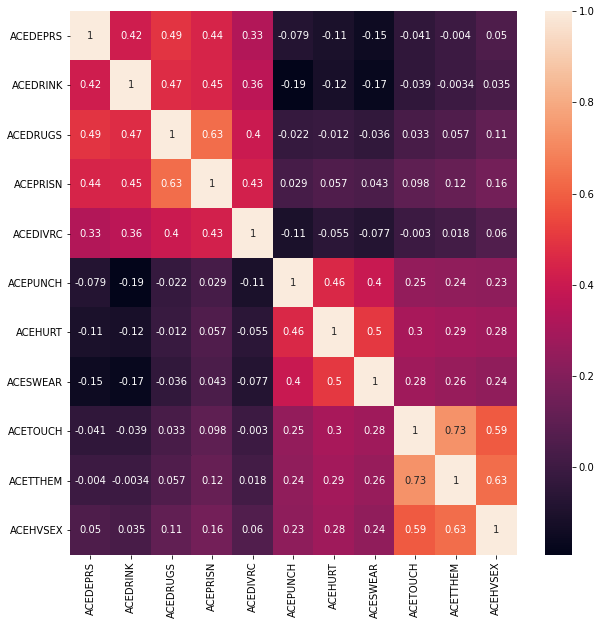

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), annot=True);

**Doesn't look like anything is too highly correlated in the ACE, except the questions on the topic of Sexual Abuse and there were slight correlations between substance abuse and mental illness.**

In [80]:
X2 = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [81]:
X2_train, X2_test, y2_train_tobacco, y2_test_tobacco = train_test_split(X2, y_tobacco, stratify=y_tobacco)
X2_train2, X2_test2, y2_train_activity, y2_test_activity = train_test_split(X2, y_activity, stratify=y_activity)
X2_train3, X2_test3, y2_train_health, y2_test_health = train_test_split(X2, y_health, stratify=y_health)
X2_train4, X2_test4, y2_train_smoker, y2_test_smoker = train_test_split(X2, y_smoker, stratify=y_smoker)

In [82]:
lr5 = LogisticRegression()
lr5.fit(X2_train, y2_train_tobacco)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [83]:
lr6 = LogisticRegression()
lr6.fit(X2_train2, y2_train_activity)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [84]:
lr7 = LogisticRegression()
lr7.fit(X2_train3, y2_train_health)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [85]:
lr8 = LogisticRegression()
lr8.fit(X2_train4, y2_train_smoker)

C:\Users\eboni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [86]:
print(f' training accuracy for tobacco: {lr5.score(X2_train, y2_train_tobacco)}')
print(f' training accuracy for activity: {lr6.score(X2_train2, y2_train_activity)}')
print(f' training accuracy for health: {lr7.score(X2_train3, y2_train_health)}')
print(f' training accuracy for smoker: {lr8.score(X2_train4, y2_train_smoker)}')

 training accuracy for tobacco: 0.9665630742009391
 training accuracy for activity: 0.7876392260054896
 training accuracy for health: 0.8630197581834267
 training accuracy for smoker: 0.5198035523898101


In [87]:
print(f' testing accuracy for tobacco: {lr5.score(X2_test, y2_test_tobacco)}')
print(f' testing accuracy for activity: {lr6.score(X2_test2, y2_test_activity)}')
print(f' testing accuracy for health: {lr7.score(X2_test3, y2_test_health)}')
print(f' testing accuracy for smoker: {lr8.score(X2_test4, y2_test_smoker)}')

 testing accuracy for tobacco: 0.9665521113341726
 testing accuracy for activity: 0.7846132906869917
 testing accuracy for health: 0.8620572322977985
 testing accuracy for smoker: 0.5206029466807309


In [88]:
tobacco2_preds = lr5.predict(X2_test)
activity2_preds = lr6.predict(X2_test2)
health2_preds = lr7.predict(X2_test3)
smoker2_preds = lr8.predict(X2_test4)

In [90]:
tobacco2_prec = precision_score(y2_test_tobacco, tobacco2_preds, average='micro')
activity2_prec = precision_score(y2_test_activity, activity2_preds, average='micro')
health2_prec = precision_score(y2_test_health, health2_preds, average='micro')
smoker2_prec = precision_score(y2_test_smoker, smoker2_preds, average='micro')

In [92]:
print(f'Precision for tobacco: {tobacco2_prec}')
print(f'Precision for activity: {activity2_prec}')
print(f'Precision for health: {health2_prec}')
print(f'Precision for smoker: {smoker2_prec}')

Precision for tobacco: 0.9665521113341726
Precision for activity: 0.7846132906869917
Precision for health: 0.8620572322977985
Precision for smoker: 0.5206029466807309


**Accuracy for activity and health increased when using all predictors, tobacco and smoker did not. Feature selection will probably be important and also using different modeling methods. Precision scores are on par with accuracy scores, as accuracy goes up, precision goes up at the same rate.**